#0. Whisper inferencing on our wav files

In [ ]:
!pip install openai-whisper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import whisper

In [ ]:
model = whisper.load_model("base")

In [ ]:
model.transcribe("/content/output_denoised.wav")

{'text': ' Bye!',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 2.0,
   'text': ' Bye!',
   'tokens': [50364, 4621, 0, 50464],
   'temperature': 0.0,
   'avg_logprob': -0.8141970634460449,
   'compression_ratio': 0.3333333333333333,
   'no_speech_prob': 0.25508996844291687}],
 'language': 'en'}

In [ ]:
model.transcribe("/content/drive/MyDrive/0019.wav")

{'text': ' dek',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 2.16,
   'text': ' dek',
   'tokens': [50364, 368, 74, 50472],
   'temperature': 1.0,
   'avg_logprob': -3.204972839355469,
   'compression_ratio': 0.2727272727272727,
   'no_speech_prob': 0.18885843455791473}],
 'language': 'de'}

In [ ]:
model.transcribe("/content/drive/MyDrive/0113.wav")

{'text': ' dark',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 2.0,
   'text': ' dark',
   'tokens': [50364, 2877, 50464],
   'temperature': 0.0,
   'avg_logprob': -0.9220072627067566,
   'compression_ratio': 0.3333333333333333,
   'no_speech_prob': 0.4527215361595154}],
 'language': 'en'}

#1. NST

In [1]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
import librosa
import librosa.display
import tifffile

*1. AIR 2. DARK 3. FOXTROT 4. GADGET*

##1. NST prep:


In [26]:
#from wav to tiff
y, sr = librosa.load("/content/GADGET/F01_Sess_01_0124.wav")
dys_song, _ = librosa.effects.trim(y)

In [27]:
n_fft=512
hop_length= 176
n_mels=128
S = librosa.feature.melspectrogram(y = dys_song, sr=sr, n_fft=n_fft, 
                                hop_length=hop_length, n_mels=n_mels)

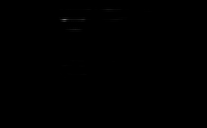

In [28]:
im =Image.fromarray(S).convert("F")
im.show()
im.save("/content/GADGET/dys.tiff")

In [29]:
#from wav to tiff
y, sr = librosa.load("/content/GADGET/FC03_Sess_01_0033.wav")
nor_song, _ = librosa.effects.trim(y)

In [30]:
S = librosa.feature.melspectrogram(y = nor_song, sr=sr, n_fft=n_fft, 
                                hop_length=hop_length, n_mels=n_mels)

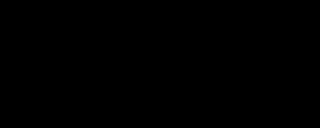

In [31]:
im =Image.fromarray(S).convert("F")
im.show()
im.save("/content/GADGET/nor.tiff")

##2. NST VGG

In [299]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [300]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [301]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path)
    N = np.array(image)
    image = np.dstack((N, N, N))
    # # large images will slow down processing
    # if max(image.size) > max_size:
    #     size = max_size
    # else:
    #     size = max(image.size)
    
    # if shape is not None:
    #     size = shape
        
    in_transform = transforms.Compose([
                        # transforms.Resize(size),
                        transforms.ToTensor(),
                        ])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [302]:
content = load_image('/content/GADGET/dys.tiff').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/GADGET/nor.tiff', shape=content.shape[-2:]).to(device)

In [303]:
content.shape

torch.Size([1, 3, 128, 207])

In [304]:
style.shape

torch.Size([1, 3, 128, 320])

In [305]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [306]:
def gram_matrix(tensor):
   
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [318]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [319]:
# weights for each style layer 
style_weights = {
                 'conv1_1': 1.00,
                 'conv2_1': 0.75,
                 'conv3_1': 0.25,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}

content_weight = 0.15e-8  # alpha
style_weight = 0.95e2 # beta


In [320]:
# for displaying the target image, intermittently
show_every = 10

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 120 # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv2_1'] - content_features['conv2_1'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        # plt.imshow(im_convert(target))
        # plt.show()

Total loss:  4291871.0
Total loss:  3964448.0
Total loss:  3727603.75
Total loss:  3535829.5
Total loss:  3374907.25
Total loss:  3237349.5
Total loss:  3115911.0
Total loss:  3008281.25
Total loss:  2911127.0
Total loss:  2821817.75
Total loss:  2739229.25
Total loss:  2661540.5


In [321]:
z = target.cpu().data.numpy().copy()

In [322]:
wav = librosa.feature.inverse.mel_to_audio(z[0][1], n_fft=512, hop_length=176, window='hann', center=True, pad_mode='reflect', power= 2.0, n_iter=500)

In [323]:
import soundfile
soundfile.write('/content/GADGET/output_vgg19.wav', wav, 22050)

In [324]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/GADGET/output_vgg19.wav', autoplay=True, normalize=False))
beep();

##2.b. NSTAlex

In [362]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
alex = models.alexnet(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in alex.parameters():
    param.requires_grad_(False)

In [363]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alex.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [364]:
content = load_image('/content/GADGET/dys.tiff').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/GADGET/nor.tiff', shape=content.shape[-2:]).to(device)

In [365]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '3': 'conv2_1', ## content representation
                  '6': 'conv3_1', 
                  '8': 'conv4_1', 
                  '10': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [366]:
def gram_matrix(tensor):
   
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [367]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [368]:
# weights for each style layer 
style_weights = {
                 'conv1_1': 1.00,
                 'conv2_1': 0.75,
                 'conv3_1': 0.25,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}

content_weight = 0.15e-8  # alpha
style_weight = 0.95e2 # beta

In [369]:
# for displaying the target image, intermittently
show_every = 10

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 100 # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv2_1'] - content_features['conv2_1'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        # plt.imshow(im_convert(target))
        # plt.show()

Total loss:  5403829.0
Total loss:  5203152.0
Total loss:  5033693.0
Total loss:  4884590.0
Total loss:  4748284.0
Total loss:  4621749.5
Total loss:  4502450.5
Total loss:  4389912.0
Total loss:  4283915.0
Total loss:  4183357.0


In [370]:
z = target.cpu().data.numpy().copy()

In [371]:
wav = librosa.feature.inverse.mel_to_audio(z[0][1], n_fft=512, hop_length=176, window='hann', center=True, pad_mode='reflect', power= 2.0, n_iter=500)

In [372]:
import soundfile
soundfile.write('/content/GADGET/output_alex.wav', wav, 22050)

In [373]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/GADGET/output_alex.wav', autoplay=True, normalize=False))
beep();

##2.C. NST VGG 16

In [338]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg16 = models.vgg16(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg16.parameters():
    param.requires_grad_(False)

In [339]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [340]:
content = load_image('/content/GADGET/dys.tiff').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/GADGET/nor.tiff', shape=content.shape[-2:]).to(device)

In [341]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '2': 'conv2_1', ## content representation
                  '5': 'conv3_1', 
                  '7': 'conv4_1', 
                  '10': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [342]:
def gram_matrix(tensor):
   
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [343]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [344]:
# weights for each style layer 
style_weights = {
                 'conv1_1': 1.00,
                 'conv2_1': 0.75,
                 'conv3_1': 0.25,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}

content_weight = 0.15e-8  # alpha
style_weight = 0.95e2 # beta

In [345]:
# for displaying the target image, intermittently
show_every = 10

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 100 # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv2_1'] - content_features['conv2_1'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        # plt.imshow(im_convert(target))
        # plt.show()

Total loss:  5403829.0
Total loss:  5203152.0
Total loss:  5033693.5
Total loss:  4884588.5
Total loss:  4748282.5
Total loss:  4621762.5
Total loss:  4502453.0
Total loss:  4389938.0
Total loss:  4283958.0
Total loss:  4183401.5


In [346]:
z = target.cpu().data.numpy().copy()

In [347]:
wav = librosa.feature.inverse.mel_to_audio(z[0][1], n_fft=512, hop_length=176, window='hann', center=True, pad_mode='reflect', power= 2.0, n_iter=500)

In [348]:
import soundfile
soundfile.write('/content/GADGET/output_vgg16.wav', wav, 22050)

In [350]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/GADGET/output_vgg16.wav', autoplay=True, normalize=False))
beep();

##3. post processing for denoising

In [374]:
import noisereduce as nr
from scipy.io import wavfile
rate, data = wavfile.read("/content/GADGET/output_alex.wav")
reduced_noise = nr.reduce_noise(y=data, sr=rate, n_fft=512, hop_length=176, win_length = n_fft)
wavfile.write("/content/GADGET/output_denoised_alex.wav", rate, reduced_noise)

In [376]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/GADGET/output_denoised_alex.wav', autoplay=True, normalize=False))
beep();

In [379]:
i = 0
for i in range(0,1):
  i += 1
  rate, data = wavfile.read("/content/GADGET/output_denoised_alex.wav")
  reduced_noise = nr.reduce_noise(y=data, sr=rate, n_fft=512, hop_length=176, win_length = n_fft)
  wavfile.write("/content/GADGET/output_denoised_alex.wav", rate, reduced_noise)

In [380]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/GADGET/output_denoised_alex.wav', autoplay=True, normalize=False, rate=0.75))
beep();

##4. Metric: Itakura-Saito Distance

In [68]:
!pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-linux_x86_64.whl size=534334 sha256=84f9feb002459903ceed4c107201e79102ec0619fcea8ec8253333a50d8b7413
  Stored in directory: /root/.cache/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [80]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [331]:
dys, sr = librosa.load("/content/GADGET/F01_Sess_01_0124.wav")
dys_song, _ = librosa.effects.trim(dys)

In [332]:
nor, sr = librosa.load("/content/GADGET/FC03_Sess_01_0033.wav")
nor_song, _ = librosa.effects.trim(nor)

In [381]:
out, sr = librosa.load("/content/GADGET/output_denoised_alex.wav")
out_song, _ = librosa.effects.trim(out)

In [382]:
def find_metric(x,y):
  diff_len = abs(len(x) - len(y))

  # Zero-pad the shorter sequence
  if len(x) < len(y):
      x = np.pad(x, (0, diff_len), 'constant')
  else:
      y = np.pad(y, (0, diff_len), 'constant')
  y = np.reshape(y, (y.shape[0],1))
  x = np.reshape(x, (x.shape[0],1))
  
  # Compute the Itakura-Saito distance between the two sequences
  distance, path = fastdtw(x, y, dist=euclidean)

  print("Itakura-Saito distance: ", distance)

In [383]:
find_metric(dys,out)

Itakura-Saito distance:  1469.9142818723685


In [384]:
find_metric(nor,out)

Itakura-Saito distance:  777.4944382869153


In [385]:
find_metric(dys,nor)

Itakura-Saito distance:  1477.5073572530519


##5. Make melspecs if necessary

#### OG normal

In [ ]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('/content/drive/MyDrive/0062.wav', autoplay=True))
beep();

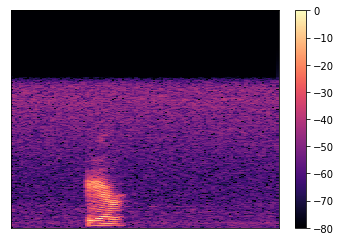

In [ ]:
y,sr = librosa.load("/content/drive/MyDrive/0062.wav")
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

#### OG dysa

In [ ]:
y1,sr = librosa.load("/content/drive/MyDrive/0059.wav", mono=True, sr=sr, offset=0, duration=10)
display(Audio(y1,rate=sr))

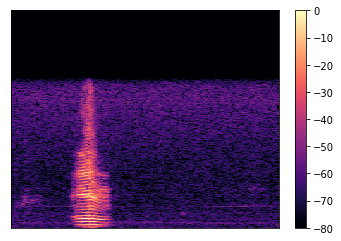

In [ ]:
y,sr = librosa.load("/content/drive/MyDrive/0059.wav")
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
y1,sr = librosa.load("/content/output_denoised.wav", mono=True, sr=sr, offset=0, duration=10)
display(Audio(y1,rate=sr))

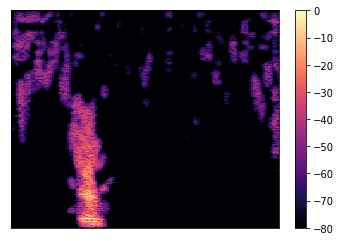

In [ ]:
y,sr = librosa.load("/content/output_denoised.wav")
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()

librosa.display.specshow(S_db)
plt.colorbar()